In [1]:
import os
import sys
import json
import pickle as pkl
import numpy as np
import pandas as pd
import arviz as az
import pymc3 as pm
import theano
import theano.tensor as T
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# read data
fp = os.path.abspath('../dataset/model_set.csv')
raw_df = pd.read_csv(fp, index_col=0)

In [3]:
# read data
fp = os.path.abspath('../dataset/model_set.csv')
raw_df = pd.read_csv(fp, index_col=0)

# feature engineering
raw_df["LogSalePrice"] = np.log(raw_df.SalePrice)
raw_df.CentralAir = [1 if i == "Y" else 0 for i in raw_df.CentralAir]
raw_df["StoneVnr"] = [1 if i == "Stone" else 0 for i in raw_df.MasVnrType]
kitch_qual_conv = {"Ex": 3, "Gd": 2, "TA": 1, "Fa": 0}
raw_df["1stFlrSF"] = raw_df["1stFlrSF"] / 100
raw_df["LotArea_acres"] = raw_df["LotArea"] / 43560.
raw_df.KitchenQual = [kitch_qual_conv[i] for i in raw_df.KitchenQual]
raw_df.YrSold = raw_df.YrSold - raw_df.YrSold.min()  # years from 2006
raw_df.YearBuilt = raw_df.YearBuilt - raw_df.YearBuilt.min()  # years from 1872
raw_df.YearRemodAdd = raw_df.YearRemodAdd - raw_df.YearRemodAdd.min()  # years from 1950
Neighborhoods = raw_df.Neighborhood.unique()
NbdLookup = dict(zip(Neighborhoods, range(Neighborhoods.size)))
raw_df["NeighborhoodCode"] = raw_df.Neighborhood.replace(NbdLookup)

In [4]:
# select only one neighborhood
raw_df = raw_df[raw_df.Neighborhood=="SawyerW"]
print(raw_df.shape)

In [5]:
### data preparation and formatting ###

# design matix
covariates = ("1stFlrSF", "LotArea_acres", "StoneVnr")
y = raw_df.LogSalePrice
X = raw_df.loc[:, covariates]
n, p = X.shape

# train-test split
train_idx, test_idx = train_test_split(range(n),
                                       test_size=0.2,
                                       random_state=1)
X_train = X.iloc[train_idx, :].reset_index(drop=True)
X_test = X.iloc[test_idx, :].reset_index(drop=True)
y_train = y.iloc[train_idx].reset_index(drop=True)
y_test = y.iloc[test_idx].reset_index(drop=True)

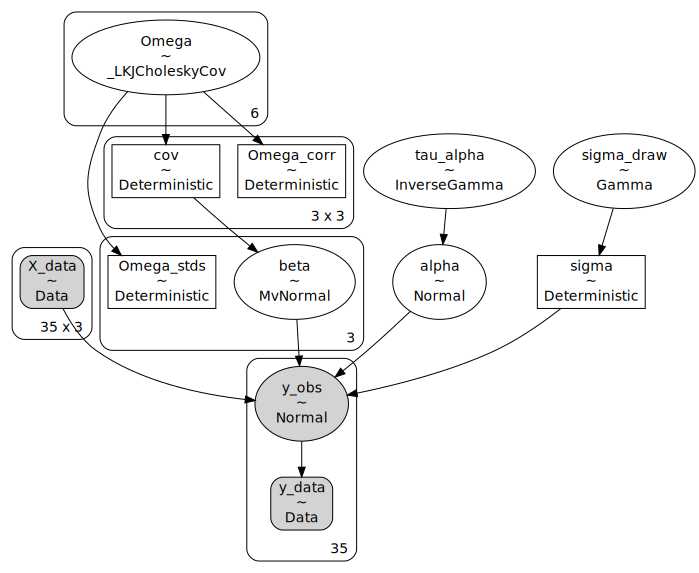

In [6]:
### modeling ###
NAmes_model = pm.Model()

Ip_mat = np.eye(p)
zerop_vec = np.zeros(p)

# specify model and perform sampling
with NAmes_model:
    X_data = pm.Data("X_data", X_train)
    y_data = pm.Data("y_data", y_train)
    # hyper priors
    chol, stds, corr = pm.LKJCholeskyCov("Omega", n=p, eta=1.,
                                         sd_dist=pm.InverseGamma.dist(alpha=2., beta=1.),
                                         compute_corr=True)
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    tau_alpha = pm.InverseGamma("tau_alpha", alpha=3., beta=0.5)
    alpha = pm.Normal("alpha", mu=12., sigma=tau_alpha)
    # priors
    #tau_beta = pm.Exponential("tau_beta", lam=3.)
    beta = pm.MvNormal("beta", mu=zerop_vec, cov=cov, shape=(p,))
    sigma_draw = pm.Gamma("sigma_draw",  alpha=24., beta=4.)
    sigma = pm.Deterministic("sigma", np.sqrt(1/sigma_draw))
    # likelihood
    Ey_x = T.add(alpha, X_data.dot(beta))  # E[Y|X]
    y_obs = pm.Normal("y_obs", mu=Ey_x, sigma=sigma, observed=y_data)

pm.model_to_graphviz(NAmes_model)

---

### Prior Predictive Checks

In [7]:
with NAmes_model:
    prpc = pm.sample_prior_predictive(samples=500, random_seed=1)

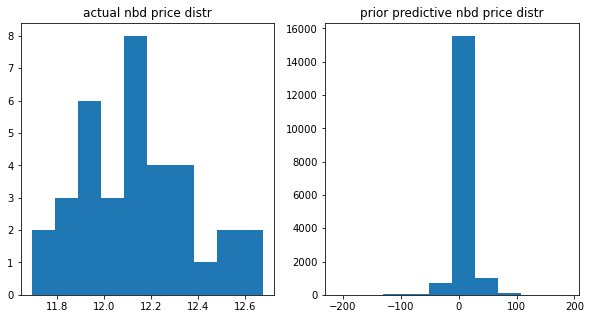

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].hist(y_train)
ax[0].set_title("actual nbd price distr")
ax[1].hist(prpc["y_obs"].reshape(-1))
ax[1].set_title("prior predictive nbd price distr")
plt.show()

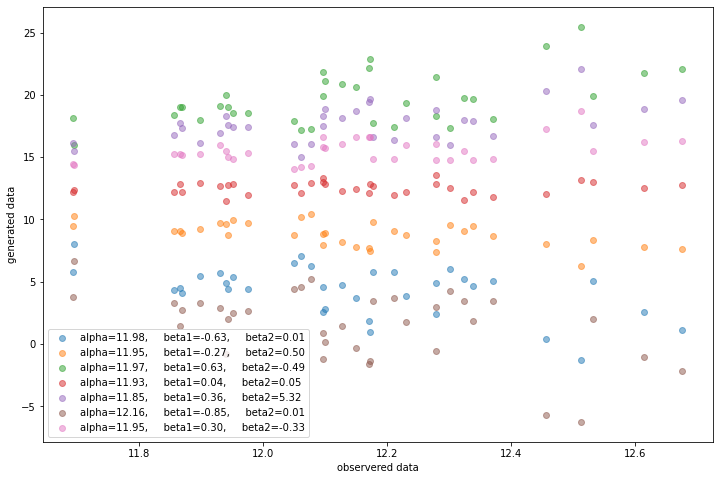

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(7):
    ax.scatter(y_train, prpc["y_obs"][i,:], alpha=0.5, label=f"alpha={prpc['alpha'][i]:.2f}, \
    beta1={prpc['beta'][:,0][i]:.2f}, \
    beta2={prpc['beta'][:,1][i]:.2f}")
ax.set(xlabel="observered data", ylabel="generated data")
ax.legend()
plt.show()

In [10]:
print(np.exp(y_train).min())
print(np.exp(y_train).max())
print(np.exp(y_train).mean())

119900.00000000004
319999.9999999998
193488.28571428565


In [11]:
print(np.exp(prpc['alpha']).min())
print(np.exp(prpc['alpha']).max())
print(np.exp(prpc['alpha']).mean())

14234.721711037573
978841.1639272246
175259.45224408127


---
## Sampling


current - 35 (changed to SawyerW)

In [12]:
with NAmes_model:
    posterior = pm.sample(draws=2000, tune=50000, cores=2,
                          init="advi+adapt_diag",
                          target_accept=0.95,
                          return_inferencedata=False,
                          random_seed=1)
    #map_est = pm.find_MAP()
    ppc = pm.fast_sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 25800
Interrupted at 25,799 [12%]: Average Loss = 820.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_draw, beta, alpha, tau_alpha, Omega]


Sampling 2 chains for 50_000 tune and 2_000 draw iterations (100_000 + 4_000 draws total) took 885 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8789047840232581, but should be close to 0.95. Try to increase the number of tuning steps.


## USE MAP ESTIMATOR TO DETERMINE IF COVAR IS IMPORTANT ENOUGH TO KEEP??

In [13]:
#map_est

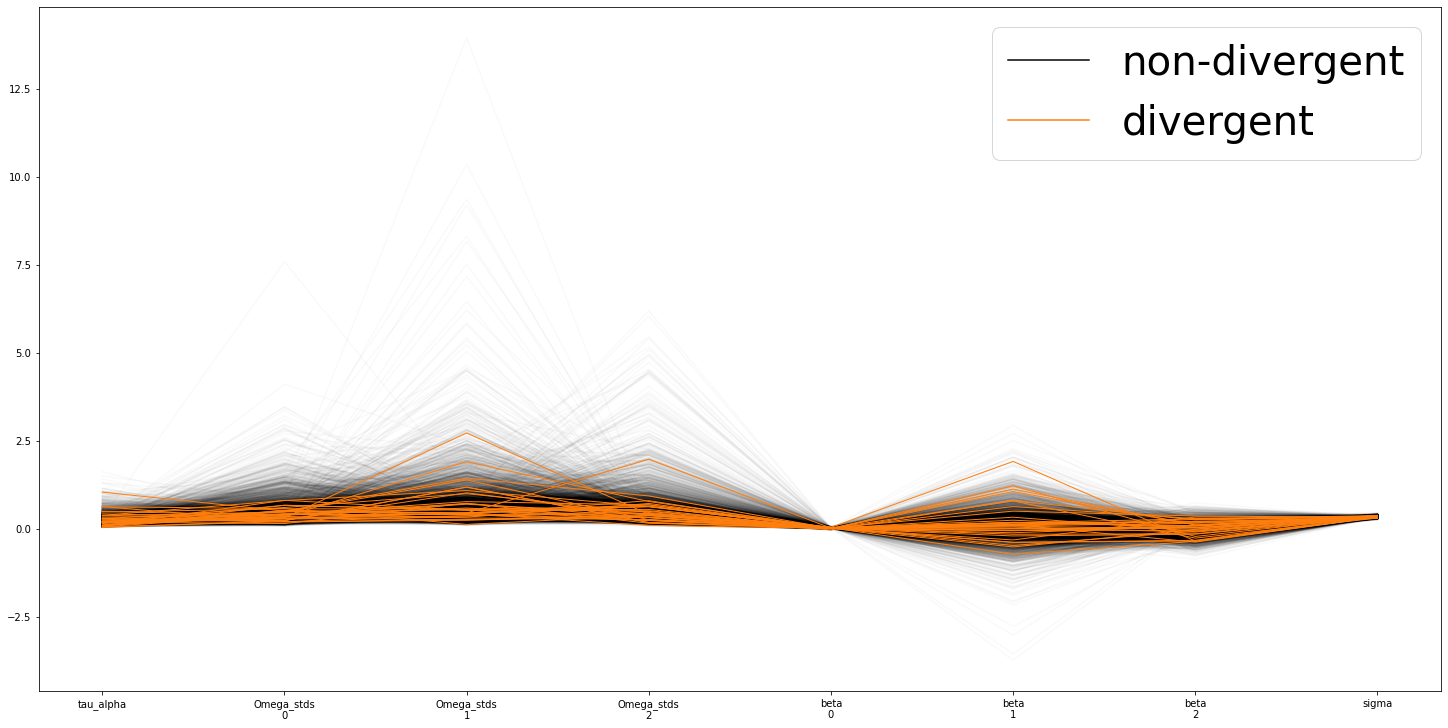

In [14]:
with NAmes_model:
    az.plot_parallel(posterior, var_names=["tau_alpha", "Omega_stds", "beta", "sigma"],
                     figsize=(20,10));

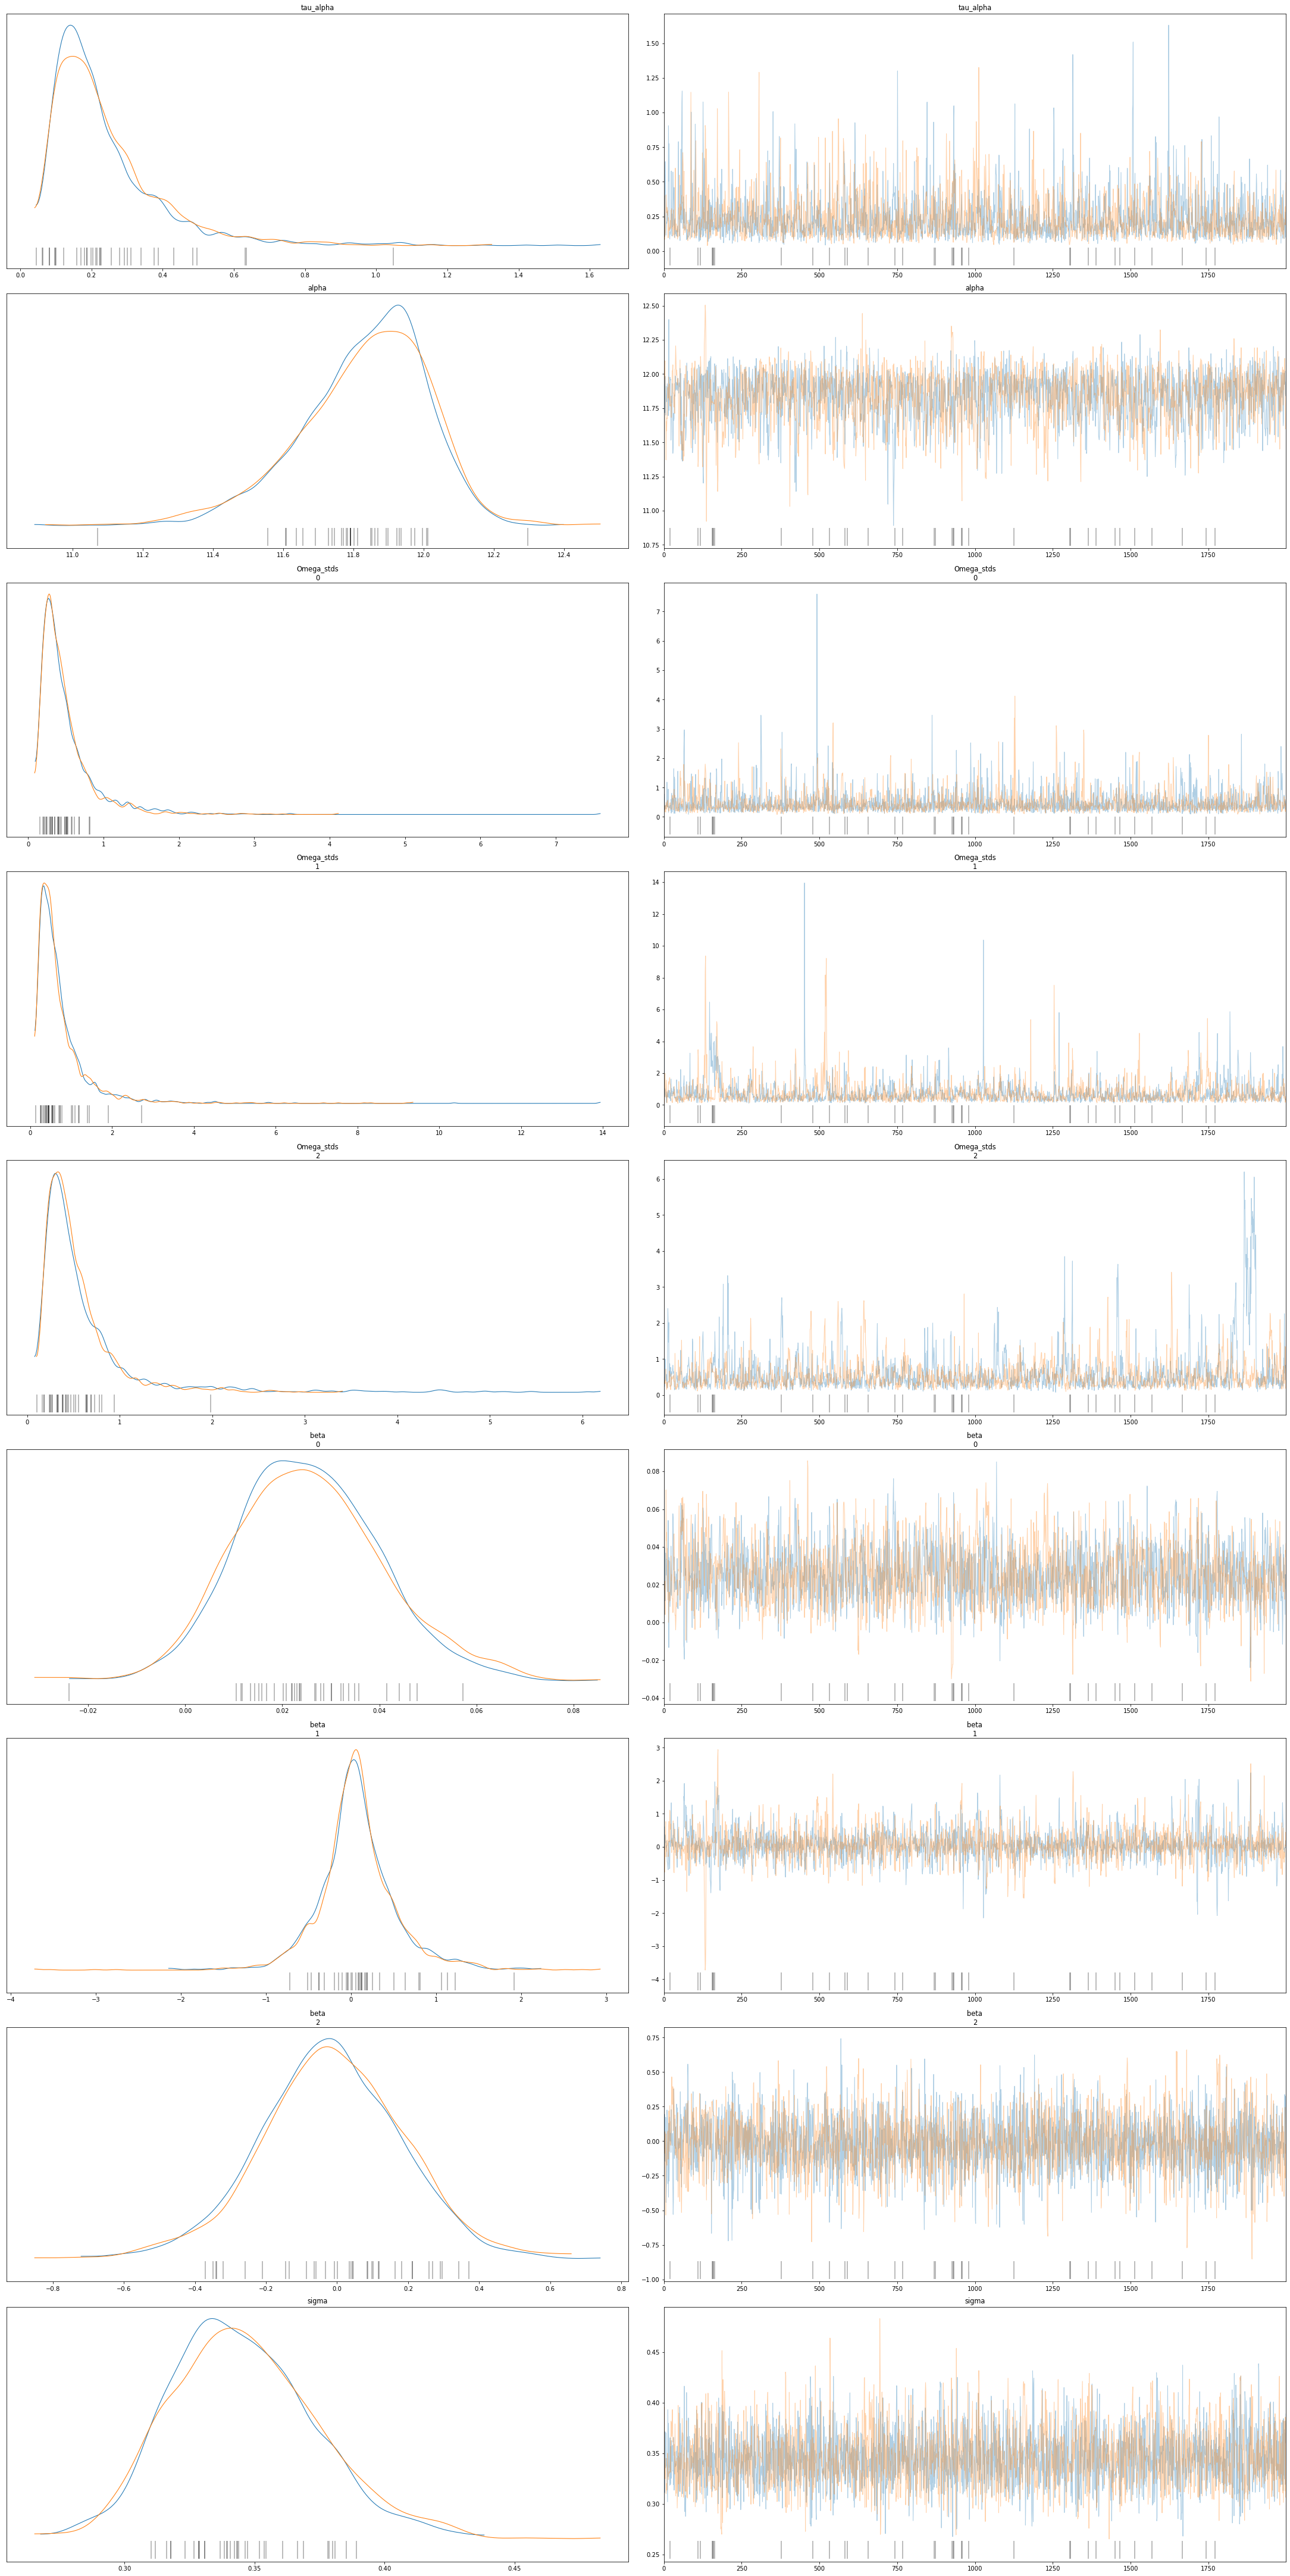

In [39]:
with NAmes_model:
    az.plot_trace(posterior,
                  var_names=["tau_alpha", "alpha", "Omega_stds", "beta", "sigma"],
                  figsize=(30,60),
                  compact=False);

In [16]:
posterior["alpha"].mean()

11.829925986105916

In [17]:
posterior["beta"].mean(axis=0)

array([ 0.02552483,  0.07460068, -0.01605077])

In [18]:
# exponentiated
np.exp(posterior["beta"].mean(axis=0))

array([1.02585337, 1.07745382, 0.98407736])

In [19]:
posterior["Omega_stds"].mean(axis=0)

array([0.49365349, 0.74548509, 0.57590819])

In [40]:
posterior["sigma"].mean()

0.34569930091006484

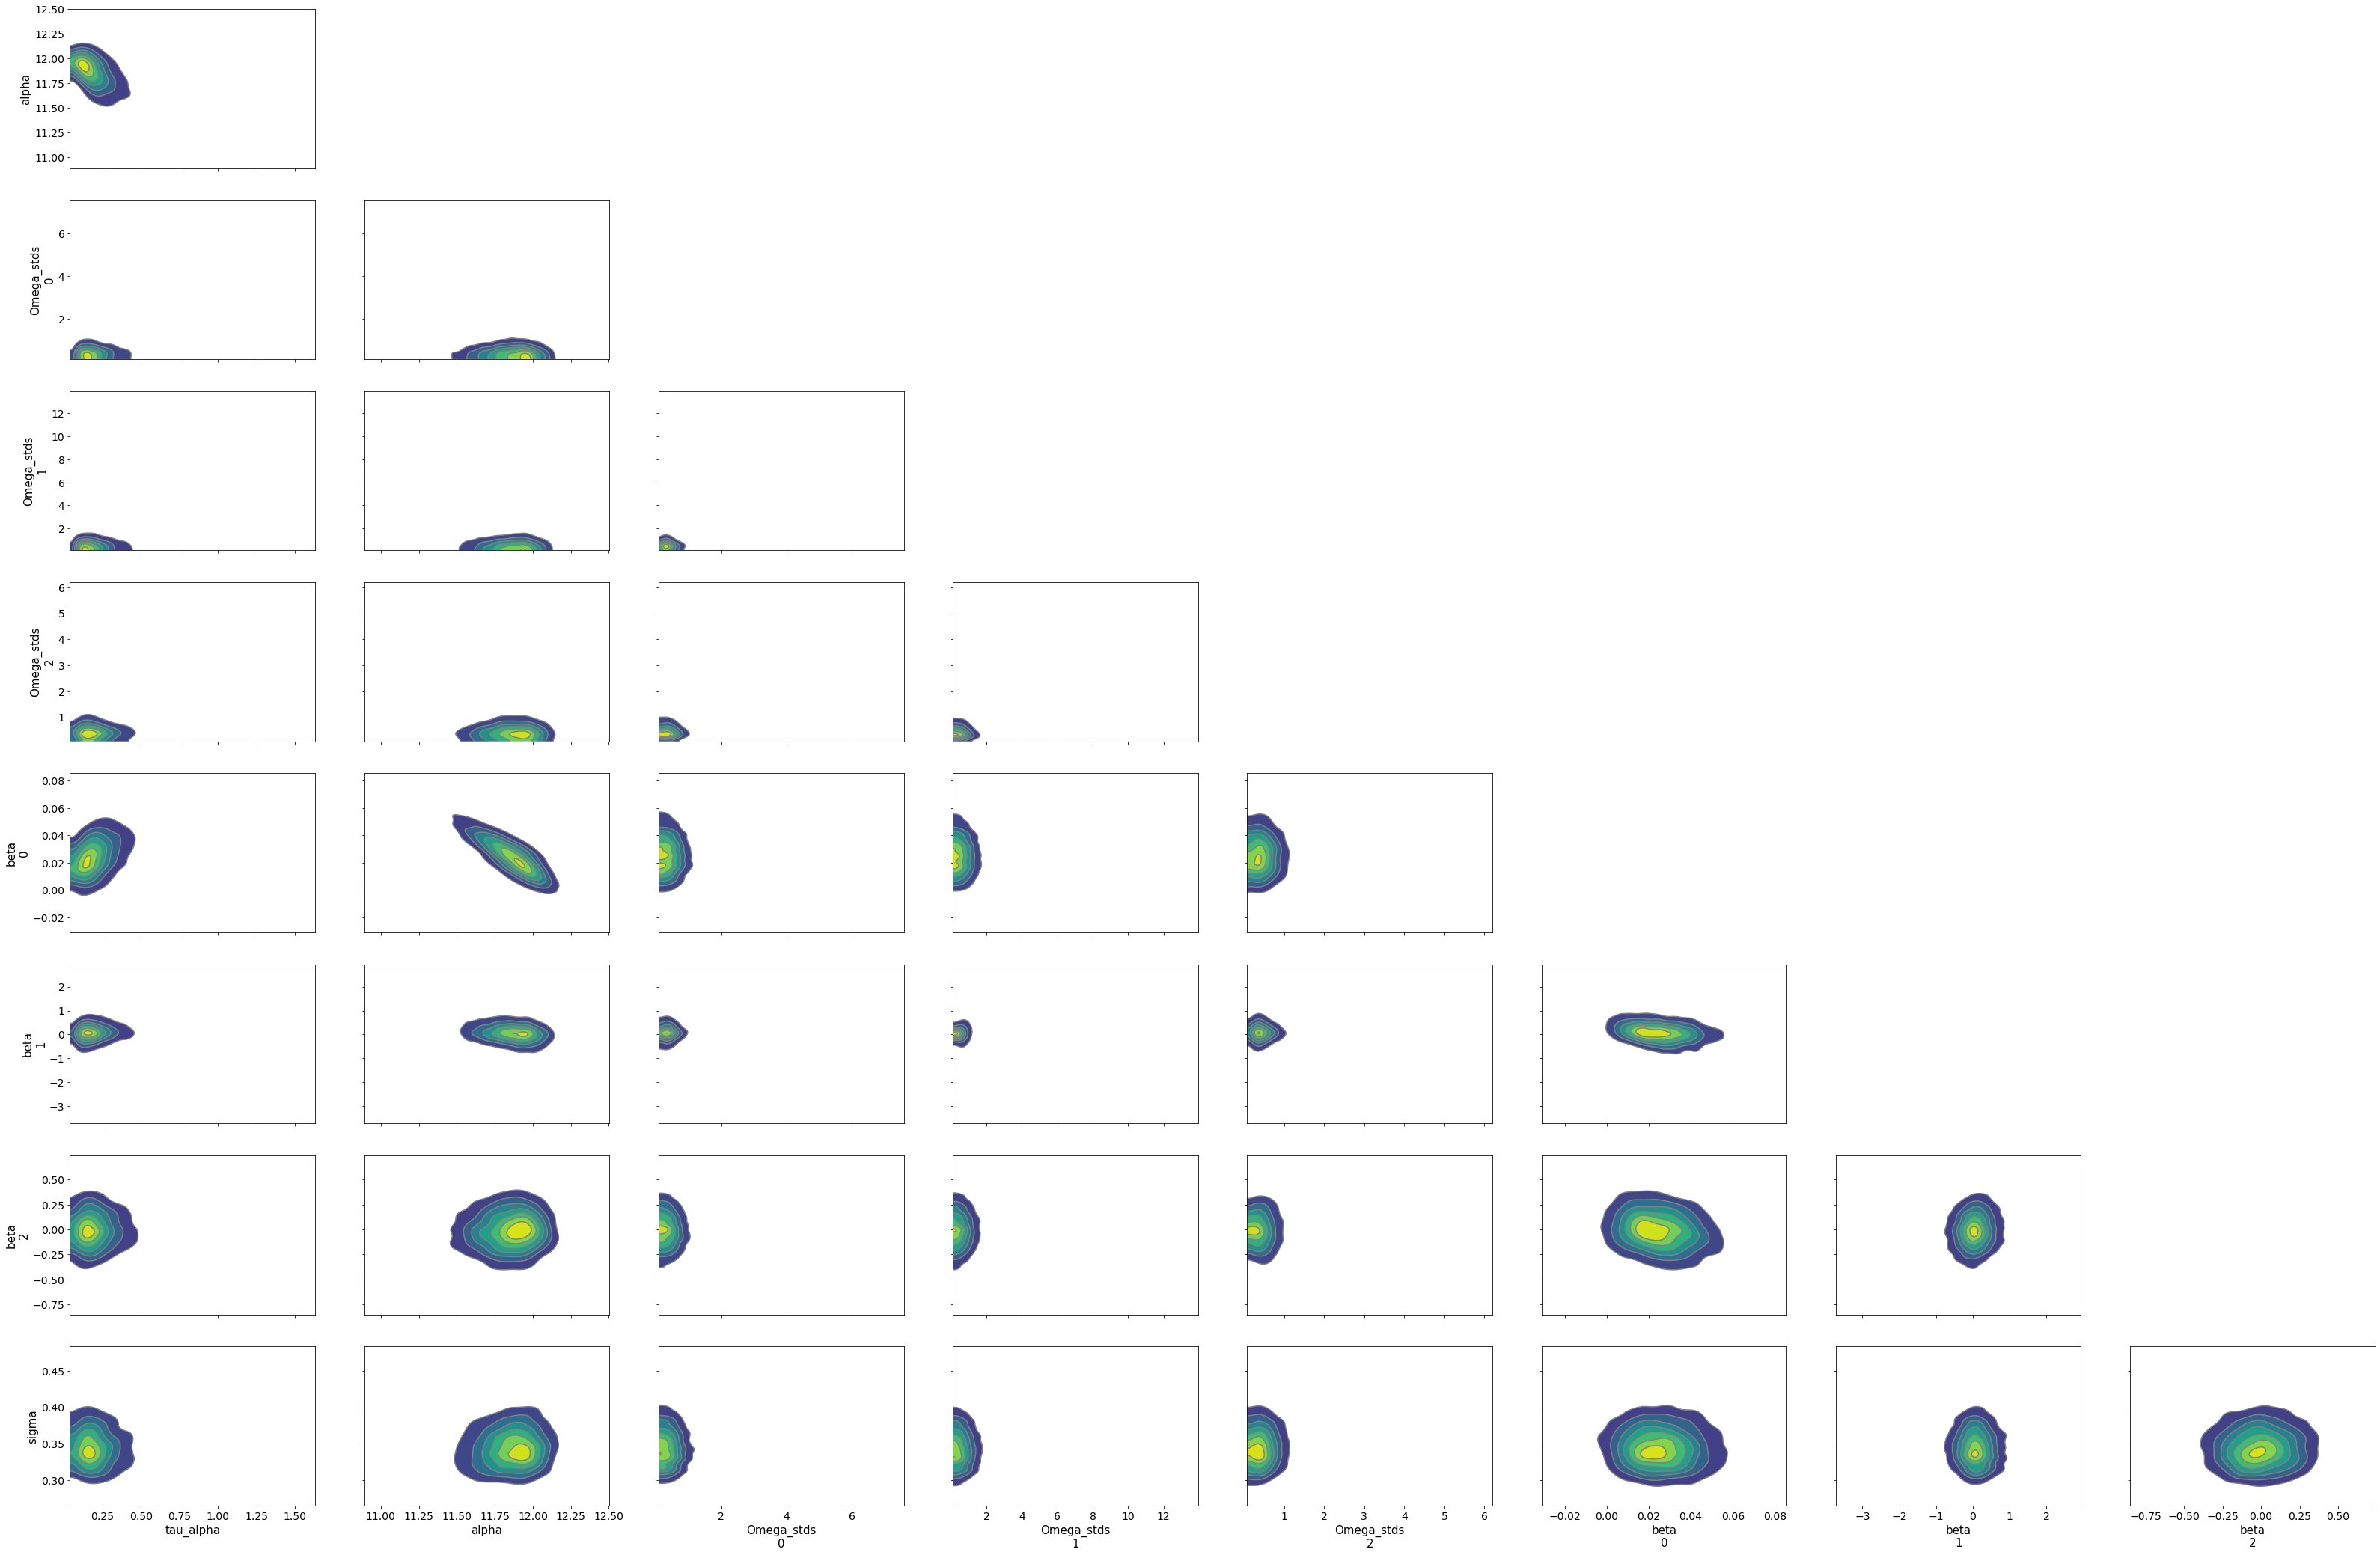

In [20]:
with NAmes_model:
    az.plot_pair(posterior, var_names=["tau_alpha", "alpha", "Omega_stds", "beta", "sigma"], kind="kde");

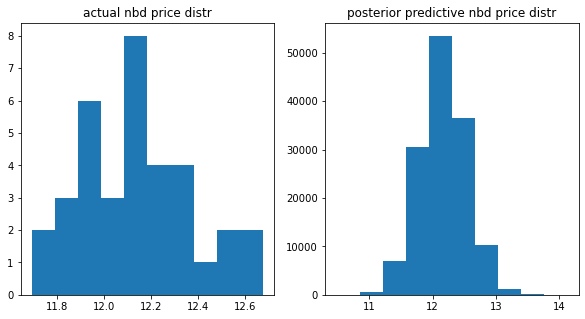

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].hist(y_train)
ax[0].set_title("actual nbd price distr")
ax[1].hist(ppc["y_obs"].reshape(-1))
ax[1].set_title("posterior predictive nbd price distr")
plt.show()

train rmse last -

In [22]:
rmse = np.sqrt(((ppc["y_obs"].mean(axis=0) - y_train)**2).mean())
rmse

0.20314036867972957

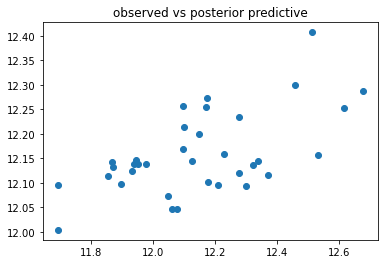

In [23]:
plt.scatter(y_train, ppc["y_obs"].mean(axis=0))
plt.title("observed vs posterior predictive")
plt.show()

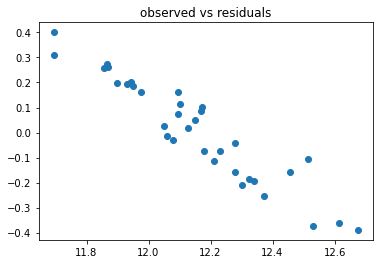

In [24]:
plt.scatter(y_train, ppc["y_obs"].mean(axis=0) - y_train)
plt.title("observed vs residuals")
plt.show()

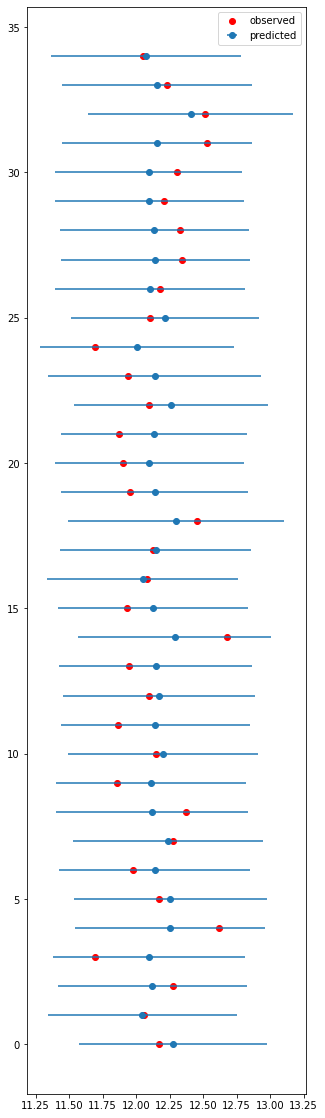

In [25]:
vidx = np.arange(y_train.size)
fig, ax = plt.subplots(figsize=(5, 20))
ax.errorbar(ppc["y_obs"].mean(axis=0), vidx,
            xerr=2*ppc["y_obs"].std(axis=0).reshape(-1),
            fmt='o',
            label="predicted")
ax.scatter(y_train, vidx, label="observed", c="red")
ax.legend()
plt.show()

---
## Predict

In [26]:
with NAmes_model:
    pm.set_data(new_data={"X_data": X_test, "y_data": y_test})
    pred = pm.sample_posterior_predictive(posterior, samples=50)

/home/samvoisin/anaconda3/envs/house_price/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


rmse last - 

In [27]:
rmse = np.sqrt(((pred["y_obs"].mean(axis=0) - y_test)**2).mean())
rmse

0.4063261766454778

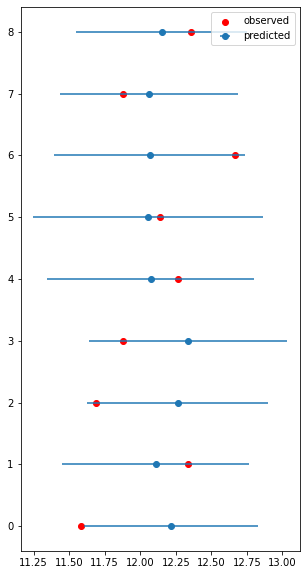

In [28]:
vidx = np.arange(y_test.size)
fig, ax = plt.subplots(figsize=(5, 10))
ax.errorbar(pred["y_obs"].mean(axis=0), vidx,
            xerr=2*pred["y_obs"].std(axis=0).reshape(-1),
            fmt='o',
            label="predicted")
ax.scatter(y_test, vidx, label="observed", c="red")
ax.legend()
plt.show()